In [1]:
import numpy as np
import pandas as pd

# Predict Air Pollution II - predict sequences

#### Exercise objectives
- Work with sequences of different lengths
- Use RNNs to return outputs for each observation in the sequences

<hr>

This exercise is a little bit different from the previous one: Here, you **observe _only_ the weather features (not the pollution)**, and you will **predict one value of air pollution *for each observation* in the input sequence**. 

What is the use-case? 
- Let's say that you have devices that are able to measure the air pollution in some places and to relate it to some weather features. That is fine! 
- But in another place, you have only weather measurements and no way to measure the air pollution.
- Then, you will use the relation between the weather features and the air pollution in some places to be able to predict the air pollution based on the weather features in another places. 

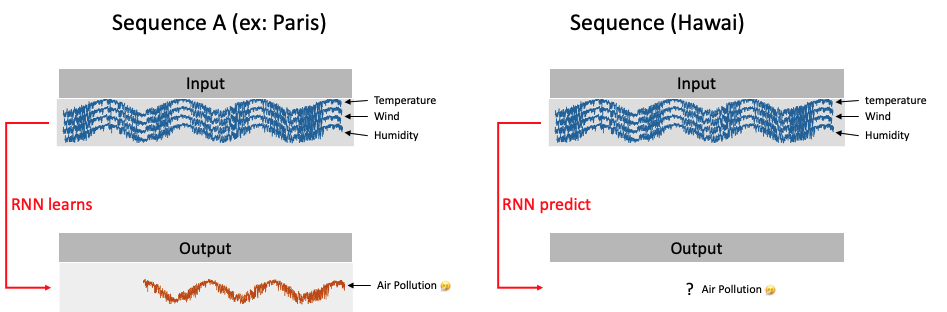

## 1. Data

👇 We load below the same dataset than in previous challenge. `pm2.5` is your target column. This time, it will not be a feature

In [2]:
df = pd.DataFrame(pd.read_csv('data.csv'))
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df.drop('No', axis=1, inplace=True)

In [4]:
df.describe()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


We separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set. We also scale the data so as to have them in the same range

In [5]:
import datetime
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

In [6]:
df.index = pd.to_datetime(df['datetime'], format = '%d.%m.%Y %H:%M:%S')

In [7]:
df.drop(['year', 'month', 'day', 'hour', 'datetime'], axis=1, inplace=True)

In [8]:
df = df.rename({'pm2.5': 'pollution'}, axis=1) 

In [9]:
df['pollution'].fillna(0, inplace=True)
df = df[24:] # drop the first day

In [10]:
df_columns = df.columns.tolist()

<AxesSubplot:xlabel='datetime'>

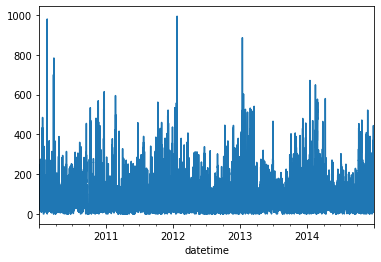

In [11]:
temp = df['pollution']
temp.plot()

In [12]:
df = df.drop(['cbwd'], axis = 1)

#df_train = df_train.drop(['datetime', 'cbwd'], axis = 1)
#df_test = df_test.drop(['datetime', 'cbwd'], axis = 1)

We separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set. We also scale the data so as to have them in the same range

In [13]:
# Time Serie split
train_size = int(len(df)*0.8)
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

Dimension of train data:  (35040, 7)
Dimension of test data:  (8760, 7)


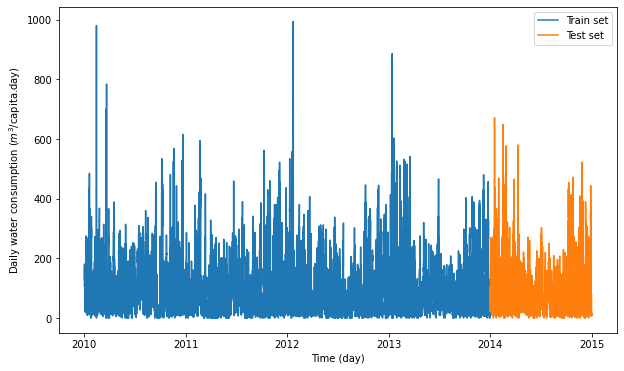

In [14]:
import matplotlib.pyplot as plt
# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(df_train['pollution'])
plt.plot(df_test['pollution'])
plt.xlabel('Time (day)')
plt.ylabel('Daily water consumption ($m^3$/capita.day)')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',df_train.shape)
print('Dimension of test data: ', df_test.shape)

In [15]:
# Scale with MinMaxScale
from sklearn.preprocessing import MinMaxScaler
columns = df.columns

scaler = MinMaxScaler(feature_range=(0, 1))
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

,pollution,DEWP,TEMP,PRES,Iws,Is,Ir
0,0.129779,0.278689,0.250000,0.527273,0.002290,0.000000,0.0
1,0.148893,0.295082,0.250000,0.527273,0.003811,0.000000,0.0
2,0.159960,0.360656,0.233333,0.545455,0.005332,0.000000,0.0
3,0.182093,0.426230,0.233333,0.563636,0.008391,0.037037,0.0
4,0.138833,0.426230,0.233333,0.563636,0.009912,0.074074,0.0


In [16]:
#[[[1], [2], [3], [4], [5]]] [6]
#[[[2], [3], [4], [5], [6]]] [7]
#[[[3], [4], [5], [6], [7]]] [8]

## 2. Prepare sequences

### 2.1 Create (X,y)

Reuse your functions from previous challenge to answer this new one:

❓ **Question** ❓ Write a function `get_X_y(df, sequence_lengths)` that, given a input dataframe `df`, returns a dataset `(X, y)` where `X` are sequences of observations and `y` are their related pollution levels.

- Each observation corresponds to the weather features : TEMP, DEWP, PRES, Ir, Is, Iws. 
- If a sequence input contains `n` observations from Day `i` to Day `i+n`, then the corresponding values to predict are the sequence of pollution levels from Day `i` to Day `i+n` too.

❗ **Remark 1** In the last exercise, all the sequences had the same lengths. Here, they change with respect to the `sequence_lengths` argument, which is a list of integers:
- For instance, if `sequence_lengths = [7, 9, 6]`, $X$ will corresponds to three sequences: the first one with 7 observations, the second one with 9 observations and the third one with 6 observations.
- the length of `sequence_lengths` corresponds to the number of sequence you want to subsample from your initial sequence
- the $i$-th value of `sequence_lengths` corresponds to the length of the $i$-th sequence.

❗ **Remark 2** You are free to do whatever you want with the missing values that are in the inputs and outputs. The idea is not to spend much time on them but to get usable data.

In [17]:
def subsample_sequence(df, length):
    index = np.random.choice(len(df)-length)
    df_sample = df.iloc[index:index+length]
    return df_sample

In [18]:
def split_subsample_sequence(df, length, df_mean=None):
    """Return one single sample (Xi, yi) containing one sequence each of length length"""
    features_names = ['TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']

    # Trick to save time during the recursive calls
    if df_mean is None:
        df_mean = df[features_names].mean()

    df_subsample = subsample_sequence(df, length).copy()

    # Let's drop any row without a target! We need targets to fit our model
    df_subsample.dropna(how='any', subset=['pollution'], inplace=True)

    # Create y_sample
    if df_subsample.shape[0] == 0: # Case if there is no targets at all remaining
        return split_subsample_sequence(df, length, df_mean) # Redraw by recursive call until it's not the case anymore
    y_sample = df_subsample[['pollution']]

    # Create X_sample

    X_sample = df_subsample[features_names]
    if X_sample.isna().sum().sum() !=0:  # Case X_sample has some NaNs
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))

    return np.array(X_sample), np.array(y_sample)

def get_X_y2(df, sequence_lengths):
    '''Return a dataset (X, y)'''
    X, y = [], []

    for length in sequence_lengths:
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    return X, y

In [81]:
X, y = get_X_y2(df_train,  sequence_lengths_train)

In [82]:
y[1].shape

(25, 1)

👇 Test your code below

In [19]:
# Here we define the parameter to generate our train/test sets
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

In [79]:
# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y2(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y2(df_test, sequence_lengths_test)

In [73]:
y_test[1].shape

(27, 1)

In [21]:
print(X_train)
print(type(X_train))

[array([[0.35      , 0.52459016, 0.65454545, 0.        , 0.        ,
        0.00458002],
       [0.36666667, 0.50819672, 0.65454545, 0.        , 0.        ,
        0.00763907],
       [0.35      , 0.50819672, 0.65454545, 0.        , 0.        ,
        0.01069811],
       [0.31666667, 0.45901639, 0.65454545, 0.        , 0.        ,
        0.01604717],
       [0.36666667, 0.45901639, 0.67272727, 0.        , 0.        ,
        0.0229172 ],
       [0.45      , 0.42622951, 0.67272727, 0.        , 0.        ,
        0.02826626],
       [0.5       , 0.37704918, 0.67272727, 0.        , 0.        ,
        0.03513629],
       [0.53333333, 0.37704918, 0.67272727, 0.        , 0.        ,
        0.04200632],
       [0.56666667, 0.3442623 , 0.65454545, 0.        , 0.        ,
        0.04887636],
       [0.6       , 0.31147541, 0.63636364, 0.        , 0.        ,
        0.05422541],
       [0.6       , 0.32786885, 0.6       , 0.        , 0.        ,
        0.00229001],
       [0.61666667, 

In [22]:
# Test if there are no NaN in you dataset
assert np.sum([np.isnan(x[0]).sum() for x in X_train]) == 0
assert np.sum([np.isnan(x[0]).sum() for x in X_test]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_train]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_test]) == 0

# Check your shapes
print("X_train type", type(X_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")
print("\n")
print("y_train type", type(y_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")

X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (26, 6)
shape sequence 1 (24, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (26, 6)
shape sequence 1 (24, 6)
...


☝️ It should look something like (with different sequence lenghts of course)
```
X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...

```

### 2.2 Padding

❓ **Question** ❓ Your input sequences have different lengths. For this reason, do not forget to pad them. For the model to work, you also need to pad your target values `y_train` and `y_test`.

You need all your sequences (train and test, X **and** y) to be of same length (not only X!). To do so, use the `maxlen=30` keyword - [see documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [23]:
value = -1500.
# YOUR CODE HERE
from keras.preprocessing import sequence
X_train_p = sequence.pad_sequences(X_train, dtype=float, padding='post', truncating='pre', maxlen =30, value = value)
y_train_p = sequence.pad_sequences(y_train, dtype=float, padding='post', truncating='pre', maxlen =30, value = value)


X_test_p = sequence.pad_sequences(X_test, dtype=float, padding='post', truncating='pre', maxlen =30, value = value)
y_test_p = sequence.pad_sequences(y_test, dtype=float, padding='post', truncating='pre', maxlen =30, value = value)

In [24]:
y_train_p.shape

(1000, 30, 1)

## 3. Model

❓ **Question** ❓ 
- Initialize the model of your choice here. But don't forget, you have to return a sequence of outputs!
- Do not forget to mask the padded values. You only need to do that for the inputs. Use the padded targets as normal targets, as they won't even be used for the loss computation anyway.
- Fit it and compare your prediction to a benchmark prediction

- Fine-tune your model by adjusting the different hyperparameters of by stacking different RNNs. You should be able to reach a MAE of about `0.05` on the test set

In [25]:
y_prediction = np.mean([_ for i in y_train for _ in i])


In [26]:
br = np.mean(np.abs([_ - y_prediction for i in y_test for _ in i]))
print(f'br MAE on the test : {br:.3f}')

br MAE on the test : 0.060


In [27]:
from keras import models, layers, optimizers
from tensorflow.keras.optimizers import *
def init_model():
    pass
    sequence_of_output = models.Sequential()
    sequence_of_output.add(layers.Masking(mask_value= value, input_shape=(30,6))) 
    sequence_of_output.add(layers.LSTM(32, return_sequences=True, activation='sigmoid'))
    sequence_of_output.add(layers.LSTM(16, return_sequences=True, activation='sigmoid')) 
    sequence_of_output.add(layers.Dense(8, activation='elu'))
    sequence_of_output.add(layers.Dense(1, activation='linear')) 
    sequence_of_output.compile(loss= 'mse', optimizer ='rmsprop', metrics=['mae'])
    sequence_of_output.compile(loss= 'mse', optimizer =RMSprop(learning_rate=0.0001), metrics=['mae'])

    return sequence_of_output
    ### YOUR CODE HERE
init_model().summary()

2022-03-11 09:02:30.416760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 30, 6)             0         
                                                                 
 lstm (LSTM)                 (None, 30, 32)            4992      
                                                                 
 lstm_1 (LSTM)               (None, 30, 16)            3136      
                                                                 
 dense (Dense)               (None, 30, 8)             136       
                                                                 
 dense_1 (Dense)             (None, 30, 1)             9         
                                                                 
Total params: 8,273
Trainable params: 8,273
Non-trainable params: 0
_________________________________________________________________


In [28]:
# YOUR CODE HERE
from keras.callbacks import ModelCheckpoint, EarlyStopping
sequence_of_output = init_model()

earlystopper = EarlyStopping(monitor='val_loss', mode= 'min'
                             , patience=10
                             , verbose=1, restore_best_weights=True)

p_history = sequence_of_output.fit(X_train_p, y_train_p
                                                , epochs=1000
                                                , validation_split=0.2, batch_size=64
                                                , verbose=0
                                                , callbacks=[earlystopper])


Restoring model weights from the end of the best epoch: 734.
Epoch 744: early stopping


In [29]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

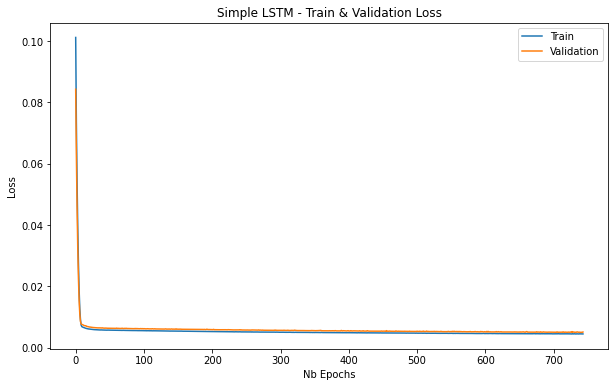

In [30]:
plot_loss(p_history, 'Simple LSTM - Train & Validation Loss')

❓ **Question** ❓ Plot many true sequences, as well as their predictions, to visualize your model performance

In [89]:
score = sequence_of_output.evaluate(X_test_p, y_test_p, verbose=0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.004289264790713787
Test accuracy: 0.055014096200466156


In [87]:
test_loss, test_loss = sequence_of_output.evaluate(X_test_p, y_test_p, verbose=0)
print('\nTest accuracy:', test_loss)



Test accuracy: 0.055014096200466156


In [164]:
train_prediction = sequence_of_output.predict(X_train_p, verbose=0)
#train_prediction = scaler.inverse_transform.reshape(X_train_p.shape)
#output = pd.DataFrame(train_prediction)

In [148]:
train_prediction.shape

(1000, 30, 1)

In [165]:
def prediction(model):
    prediction = model.predict(X_train_p)

    return prediction

In [166]:
prediction_lstm = prediction(sequence_of_output)

In [171]:
def plot_future(prediction, name_name, y_test_p):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test_p), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + name_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')

ValueError: x and y must have same first dimension, but have shapes (1000,) and (200, 30, 1)

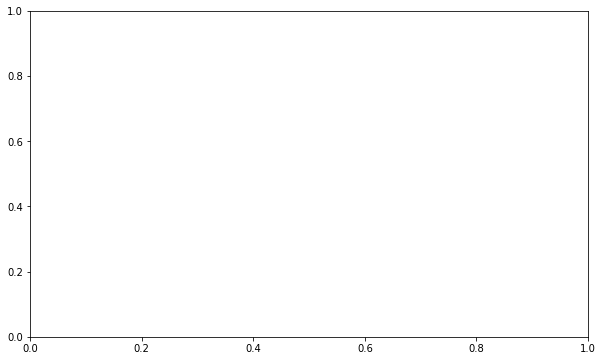

In [172]:
plot_future(prediction_lstm, 'sequence_of_output', y_test_p)

🏁 **Congratulation**